### CapacityExpansion.jl ###

In this notebook, we explore the basics of using an electricity capacity expansion model built by Holger Teichgraeber and Elias Küpper

The Julia version run on my computer is 1.1.0

In [1]:
VERSION #Julia version

v"1.1.0"

Packages used include CapacityExpansion.jl, the package explored, as well as others for data preprocessing, time-series clustering, plotting and convex optimization

In [14]:
# Packages used
import Pkg
using Pkg

Pkg.add(["Clp","Plots","StatsPlots", "DataFrames", "CSV"])
#Pkg.add(PackageSpec(url="https://github.com/YoungFaithful/CapacityExpansion.jl", rev="master"))

Pkg.pin("CapacityExpansion") # The model is continuously being improved, so pin to this version so code runs in future
# load packages - you must do this every time you restart julia
using CapacityExpansion, Clp, Plots, StatsPlots, DataFrames, CSV


 Resolving package versions...
  Updating `C:\Users\fayoola\.julia\environments\v1.1\Project.toml`
 [no changes]
  Updating `C:\Users\fayoola\.julia\environments\v1.1\Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `C:\Users\fayoola\.julia\environments\v1.1\Project.toml`
  [c5f7ca31] ~ CapacityExpansion v0.2.0 #master (https://github.com/YoungFaithful/CapacityExpansion.jl) ⇒ v0.2.0 #master (https://github.com/YoungFaithful/CapacityExpansion.jl) ⚲
  Updating `C:\Users\fayoola\.julia\environments\v1.1\Manifest.toml`
  [c5f7ca31] ~ CapacityExpansion v0.2.0 #master (https://github.com/YoungFaithful/CapacityExpansion.jl) ⇒ v0.2.0 #master (https://github.com/YoungFaithful/CapacityExpansion.jl) ⚲


Plot functions used to plot results. Don't worry too much about this part.

In [15]:
# Plot script included to plot results

## dependencies
using Plots, StatsPlots, DataFrames, CSV

## create some helper functions ##
function plotcapacity(results,outputname;save=true)
    nruns = length(results)
    # extract descriptors
    descriptors = Array{String,1}(undef,nruns)
    for i in 1:nruns
        descriptors[i] = results[i].config["descriptor"]
    end

    # number of techs
    techlength = zeros(nruns)
    for i in 1:nruns
        techlength[i] = length(axes(results[i].variables["CAP"],1)) #1 is tech/tech_cap
    end
    techlength = convert(Array{Int64},techlength)
    maxnumind = argmax(techlength)
    technames = axes(results[maxnumind].variables["CAP"],1)
    ntechs = length(technames)

    # extract capacities
    capdat = zeros(ntechs,nruns)
    for i in 1:nruns
        capdat[1:techlength[i],i] = sum(results[i].variables["CAP"][:,:,:],dims=(2,3))
    end
    categories = repeat(descriptors, inner = ntechs)
    labs = repeat(technames, outer = nruns)

    # make a dataframe of results, save as CSV
    resultdf = convert(DataFrame,capdat)
    names!(resultdf,Symbol.(descriptors))
    resultdf[:techtype]=technames
    CSV.write(outputname*"capdat.csv",resultdf)
    print(resultdf)

    outplot = groupedbar(labs, capdat, group=categories, title = "Installed Capacity", legend=:topleft)
    if save
        savefig(outputname*"capdat.png")
    end
    return outplot
end

function plotcost(results,outputname,costtype;save=true) #cost type can be 1(var), 2(cap), or 3(total)
    # if (costtype!=1) & (costtype!=2) & (costtype!=3)
    #     error("second argument (costtype) must be 1,2, or 3")
    # end
    costnames = ["Variable","Capital-Fixed","Total"]
    println("plotting " * costnames[costtype] * " costs")
    nruns = length(results)
    # extract descriptors
    descriptors = Array{String,1}(undef,nruns)
    for i in 1:nruns
        descriptors[i] = results[i].config["descriptor"]
    end

    # get costs - var, cap, tot
    costs = zeros(3,nruns)
    for i in 1:nruns
        allcosts = results[i].variables["COST"]
        costs[1,i]= sum(allcosts["var","EUR",:])#var cost
        costs[2,i]= sum(allcosts["cap_fix","EUR",:])#cap cost
        costs[3,i]= sum(allcosts[:,"EUR",:])#cap cost
    end
    resultdf = convert(DataFrame,costs)
    names!(resultdf,Symbol.(descriptors))
    resultdf[:costtype] = costnames
    CSV.write(costnames[costtype]*"_cost-"*outputname*".csv",resultdf)
    print(resultdf)

    outplot = bar(descriptors ,costs[costtype,:], title = costnames[costtype]*" Costs", legend = false)
    if save
        savefig(costnames[costtype]*"_cost-"*outputname*".png")
    end
    return outplot
end

function plotgen(results, outputname, ts_clust_data;save=true)
    nruns = length(results)
    # extract descriptors
    descriptors = Array{String,1}(undef,nruns)
    for i in 1:nruns
        descriptors[i] = results[i].config["descriptor"]
    end

    # number of techs
    techlength = zeros(nruns)
    for i in 1:nruns
        techlength[i] = length(axes(results[i].variables["GEN"],1)) #first dim is "tech"/"tech_power"
    end
    techlength = convert(Array{Int64},techlength)
    
    maxnumind = argmax(techlength)
    technames = axes(results[maxnumind].variables["GEN"],1)
    ntechs = length(technames)
    
    # extract generation
    gendat = zeros(ntechs,nruns)
    kweights = ts_clust_data.weights

    for i in 1:nruns
        # get generation for each K
        
        genK = sum(results[i].variables["GEN"][:,"electricity",:,:,:],dims=(2,4))
        print(typeof(genK))
        # produces a 5×1×5 Array{Float64,3}:  # looks more like Array{float64,4} of 6 x 1 x 5 x 1
        # dims are tech, time_T, and time_K
        
        # weight by K
        for i in 1:length(kweights)
            genK[:,:,i,:] = genK[:,:,i,:] * kweights[i]
        end
        # find weighted gen
        
        gendat[1:techlength[i],i] = sum(genK, dims=(2,3))
    end

    resultdf = convert(DataFrame,gendat)
    names!(resultdf,Symbol.(descriptors))
    resultdf[:techtype]=technames
    CSV.write(outputname*"gendat.csv",resultdf)
    print(resultdf)

    categories = repeat(descriptors, inner = ntechs)
    labs = repeat(technames, outer = nruns)
    outplot = groupedbar(labs, gendat, group=categories, title = "Total Generation", legend =:topleft)
    if save
        savefig(outputname*"gendat.png")
    end
    return outplot
end


plotgen (generic function with 1 method)

Set up the data. In this case, the default data is used (demand in Germany for 2018), preprocessed into an hourly timeseries, with k-means clustering (See Holger's ClustForOpt.jl, renamed TimeSeriesClustering.jl, if you're more interested in how this is done)

In [16]:

state="GER_18" # In-built demand data
years=[2015] 

# load non-timeseries data, which contains information on costs, nodes, technology and transmission
cep_data = load_cep_data_provided(state);

# load timeseries data at 24 hour refinement
ts_input_data = load_timeseries_data_provided(state;T=24, years=years); #CEP

# cluster timeseries data - run aggregation with k-means clustering algorithm with k = 5
ts_clust_data = run_clust(ts_input_data;method="kmeans",representation="centroid",n_init=1,n_clust=5).clust_data;

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = load_cep_data_nodes(::String, ::OptVariable{OptDataCEPTech,1,Tuple{Array{Any,1}},Tuple{Dict{Any,Int64}}}) at load_data.jl:118
└ @ CapacityExpansion C:\Users\fayoola\.julia\packages\CapacityExpansion\XOKkR\src\utils\load_data.jl:118
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = load_cep_data_lines(::String, ::OptVariable{OptDataCEPTech,1,Tuple{Array{Any,1}},Tuple{Dict{Any,Int64}}}) at load_data.jl:162
└ @ CapacityExpansion C:\Users\fayoola\.julia\packages\CapacityExpansion\XOKkR\src\utils\load_data.jl:162
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = load_cep_data_lines(::String, ::OptVariable{OptDataCEPTech,1,Tuple{Array{Any,1}},Tuple{Dict{Any,Int64}}}) at load_data.jl:162
└ @ CapacityExpansion C:\Users\fayoola\.julia\packages\Capa

Set up the optimizer. Clp is used.

In [17]:
optimizer=Clp.Optimizer

Clp.Optimizer

Run scenarios for green-build where the emissions constraint cap is varied from 10-50 kgCO2eq/MWh

In [18]:
@time greenfield_1 = run_opt(ts_clust_data,cep_data,optimizer;
    descriptor = "greenf_1", limit_emission=Dict{String,Number}("CO2/electricity"=>10));
@time greenfield_2 = run_opt(ts_clust_data,cep_data,optimizer;
    descriptor = "greenf_2", limit_emission=Dict{String,Number}("CO2/electricity"=>25));
@time greenfield_3 = run_opt(ts_clust_data,cep_data,optimizer;
    descriptor = "greenf_3", limit_emission=Dict{String,Number}("CO2/electricity"=>50));

┌ Info: Solved Scenario greenf_1: OPTIMAL min COST: 4.085e10 [EUR] ⇨ 80.67 [EUR per MWh] s.t. CO2-Emission ≤ 10 [kg-CO2-eq. per MWh-electricity],
└ @ CapacityExpansion C:\Users\fayoola\.julia\packages\CapacityExpansion\XOKkR\src\optim_problems\opt.jl:718


 23.249138 seconds (60.69 M allocations: 3.231 GiB, 7.17% gc time)
  3.675678 seconds (3.42 M allocations: 419.275 MiB, 6.72% gc time)

┌ Info: Solved Scenario greenf_2: OPTIMAL min COST: 3.9e10 [EUR] ⇨ 77.02 [EUR per MWh] s.t. CO2-Emission ≤ 25 [kg-CO2-eq. per MWh-electricity],
└ @ CapacityExpansion C:\Users\fayoola\.julia\packages\CapacityExpansion\XOKkR\src\optim_problems\opt.jl:718



  3.653248 seconds (3.42 M allocations: 419.284 MiB, 3.44% gc time)
Coin0506I Presolve 10199 (-13814) rows, 10186 (-3014) columns and 38964 (-35516) elements
Clp0006I 0  Obj 0 Primal inf 26903.865 (120) Dual inf 6.2506456e+14 (10078)
Clp0006I 275  Obj 70.535581 Dual inf 1075.3705 (2283)
Clp0006I 550  Obj 47.587855 Dual inf 21.579951 (2222)
Clp0006I 825  Obj 41.898025 Dual inf 53.573536 (473)
Clp0006I 1100  Obj 41.294928 Dual inf 97.288938 (2242)
Clp0006I 1375  Obj 40.91488 Dual inf 5.9658467 (70)
Clp0006I 1447  Obj 40.848889
Clp0000I Optimal - objective value 40.848889
Coin0511I After Postsolve, objective 40.848889, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 40.84888948 - 1447 iterations time 0.092, Presolve 0.04
Coin0506I Presolve 10199 (-13814) rows, 10186 (-3014) columns and 38964 (-35516) elements
Clp0006I 0  Obj 0 Primal inf 26903.865 (120) Dual inf 6.2506456e+14 (10078)
Clp0006I 275  Obj 74.989436 Dual inf 88.407071 (537)
Clp0006I 550  Obj 48.238545 Du

┌ Info: Solved Scenario greenf_3: OPTIMAL min COST: 3.785e10 [EUR] ⇨ 74.75 [EUR per MWh] s.t. CO2-Emission ≤ 50 [kg-CO2-eq. per MWh-electricity],
└ @ CapacityExpansion C:\Users\fayoola\.julia\packages\CapacityExpansion\XOKkR\src\optim_problems\opt.jl:718


Plot results for both generation capacity built, energy dispatched and associated annual costs, both variable and capital.

6×4 DataFrame
│ Row │ greenf_1     │ gre

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = #plotcapacity#3(::Bool, ::Function, ::Array{OptResult,1}, ::String) at In[15]:36
└ @ Main .\In[15]:36


enf_2     │ greenf_3  │ techtype │
│     │ Float64      │ Float64      │ Float64   │ String   │
├─────┼──────────────┼──────────────┼───────────┼──────────┤
│ 1   │ 14195.5      │ 15389.8      │ 15791.0   │ pv       │
│ 2   │ -5.03449e-11 │ -5.03449e-11 │ 2730.09   │ coal     │
│ 3   │ 8111.06      │ 12223.0      │ 11824.4   │ gas      │
│ 4   │ 18.0         │ 18.0         │ 18.0      │ demand   │
│ 5   │ 2.25997e5    │ 2.07956e5    │ 1.98209e5 │ wind     │
│ 6   │ 0.0          │ 0.0          │ 0.0       │ oil      │

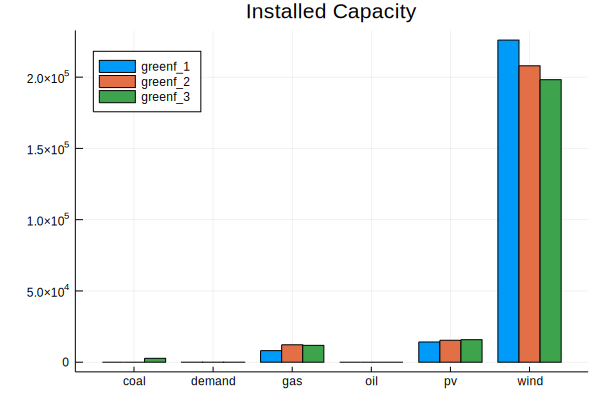

In [19]:
result =  [greenfield_1, greenfield_2, greenfield_3]

plotcapacity(result,"baseruncapacity")

Array{Float64,4}Array{Float64,4}Array{Float64,4}6×4 DataFrame
│ Row │ greenf_1    │ greenf_2    │ greenf_3   │ techtype │
│     │ Float64     │ Float64     │ Float64    │ String   │
├─────┼───────

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = #plotgen#5(::Bool, ::Function, ::Array{OptResult,1}, ::String, ::ClustData) at In[15]:123
└ @ Main .\In[15]:123


──────┼─────────────┼────────────┼──────────┤
│ 1   │ 1.00159e7   │ 1.49763e7   │ 1.69465e7  │ pv       │
│ 2   │ -2.94229e-6 │ 2.51187e-6  │ 1.10159e7  │ coal     │
│ 3   │ 6.93437e6   │ 1.73584e7   │ 1.63262e7  │ gas      │
│ 4   │ -5.06373e8  │ -5.06373e8  │ -5.06373e8 │ demand   │
│ 5   │ 4.89423e8   │ 4.74039e8   │ 4.62085e8  │ wind     │
│ 6   │ -1.67906e-6 │ -1.60197e-6 │ 0.0        │ oil      │

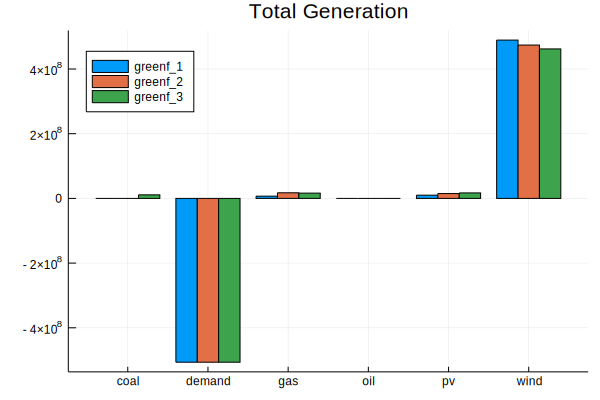

In [20]:
plotgen(result,"baserungeneration",ts_clust_data)

plotting Variable costs
3×4 DataFrame
│ Row │ greenf_1   │ greenf_2   │ greenf_3   │ costtype      │
│     │ Float64    │ Float64    │ Float64    │ String        │
├─────┼────────────┼────────────┼────────────┼───────────────┤
│ 1   │ 6.00266e8  │ 1.50261e9  │ 1.53122e9  │ Variable      │
│ 2   │ 4.02486e10 │ 3.74969e10 │ 3.6318e10  │ Capital-Fixed │
│ 3   │ 4.08489e10 │ 3.89995e10 │ 3.78492e10 │ Total        

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = #plotcost#4(::Bool, ::Function, ::Array{OptResult,1}, ::String, ::Int64) at In[15]:70
└ @ Main .\In[15]:70


 │

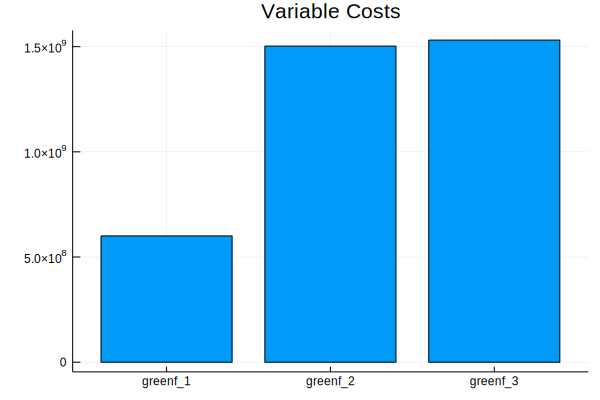

In [21]:
plotcost(result,"basevarcost", 1) # index 1 represents variable costs

plotting Capital-Fixed costs
3×4 DataFrame
│ Row │ greenf_1   │ greenf_2   │ greenf_3   │ costtype      │
│     │ Float64    │ Float64    │ Float64    │ String        │
├─────┼────────────┼────────────┼────────────┼───────────────┤
│ 1   │ 6.00266e8  │ 1.50261e9  │ 1.53122e9  │ Variable      │
│ 2   │ 4.02486e10 │ 3.74969e10 │ 3.6318e10  │ Capital-Fixed │
│ 3   │ 4.08489e10 │ 3.89995e10 │ 3.78492e10 │ Total         │

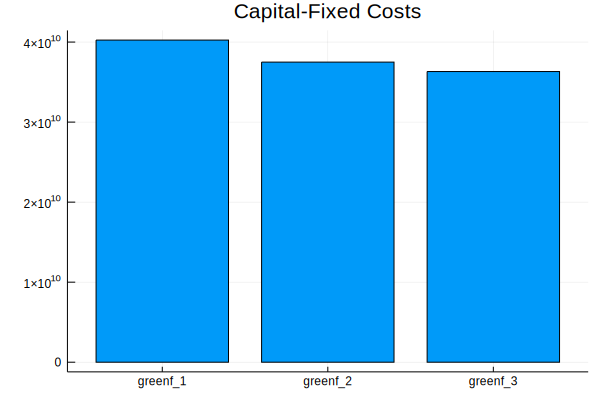

In [22]:
plotcost(result,"basecapcost", 2) # index 2 represents capital costs